<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# Practical 7: Image Manipulation and Pre-processing

Unlike text data, images can be manipulated in many different ways and yet still result in a recognisable image (at least to humans!). However, whether gathering a new dataset, or using and existing one, it is often necessary to ensure images are of a consistent size/scale and contain a similar range of colours etc. Particularly when it comes to inference, new images that are not consistent with the training data will likely confuse the model. Therefore, we still need to perform some pre-processing and normalisation steps on the images before training the model.

Data augmentation is also much simpler with image data. We can randomly change the rotation, flip, crop, or transform the image to generate new data and/or add random noise to the data and help avoid overfitting and improve generalisation.

In the first part of this practical we will examine several image manipulation and pre-processing steps as well as some techniques for finding the properties of image regions and performing simple image segmentation.

In the second part of this practical we will apply some of these techniques to create a small dataset of handwritten digits. We will also look at different methods of data augmentation which can increase the number of unique images for training purposes and add noise to the data to reduce overfitting.

The objectives of this practical are:
1. Understand various image manipulation and pre-processing options and determine which are appropriate for a given problem

2. Develop an image pre-processing pipeline to standardise images for classification

3. Explore various image augmentation techniques

# 1 Image Manipulation and Pre-processing

## 1.0 Import libraries

1. [scikit-image](https://scikit-image.org/) - is a Python library containing a collection of algorithms for  image processing.

2. [OpenCV](https://opencv.org/) - is an open-source library with tools for image processing, object detection, face recognition and image segmentation. We will use the [Python installation.](https://pypi.org/project/opencv-python/)

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage import io, feature
from skimage.color import rgb2gray, label2rgb
from skimage.transform import resize, rescale, rotate, warp, AffineTransform, SimilarityTransform, ProjectiveTransform
from skimage.filters import gaussian, threshold_otsu, threshold_mean
from skimage.measure import regionprops, label
from skimage.exposure import adjust_gamma
from skimage.util import img_as_ubyte
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the shared images folder (should be in shared/images)
images_dir = os.path.join(path, '..', 'shared', 'images')

# Set the directory to the data folder (should be in ML-LV/data/digits)
data_dir = os.path.join(path, 'data', 'digits')

# Create the directory if it doesn't exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(os.path.join(data_dir, 'my_digits')):
    os.makedirs(os.path.join(data_dir, 'my_digits'))

## 1.1 Pre-processing options

The following cells demonstrate each of the pre-processing options discussed in the lecture. For most we use scikit-image and open CV.

It is very unlikely, you would ever need to apply **all** of these steps. But it is important to understand what each does and when they might be appropriate.

### Greyscale and Separate Channels

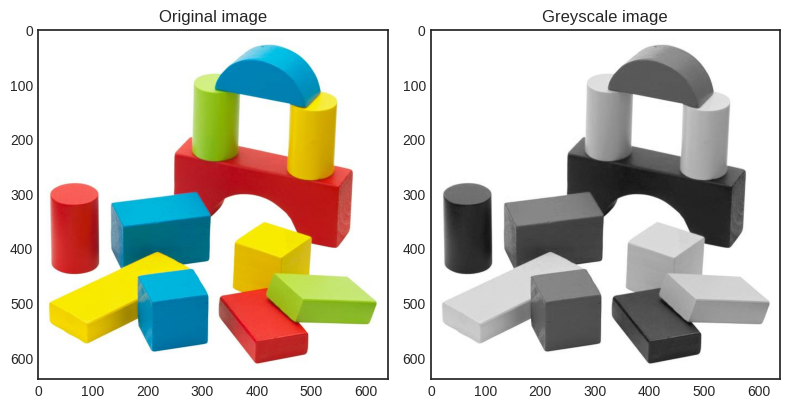

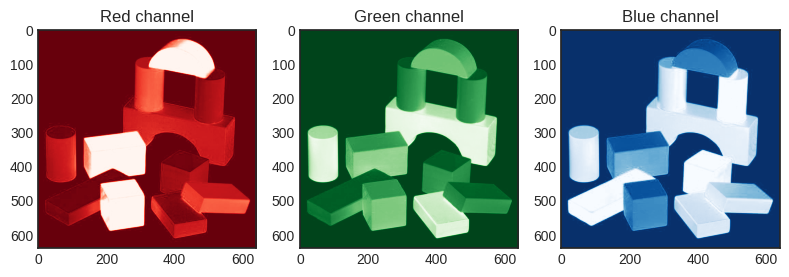

In [2]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Convert to greyscale
blocks_greyscale = rgb2gray(blocks_original)

# Separate the channels
red_channel = blocks_original[..., 0]
green_channel = blocks_original[..., 1]
blue_channel = blocks_original[..., 2]

# Plot the original image
fig, axes = plt.subplots(1, 2, figsize=(8, 6))
axes[0].imshow(blocks_original)
axes[0].set_title('Original image')
axes[1].imshow(blocks_greyscale, cmap='gray')
axes[1].set_title('Greyscale image')
fig.tight_layout()
plt.show()

# Plot the channels
fig, ax = plt.subplots(1, 3, figsize=(8, 6))
ax[0].imshow(red_channel, cmap='Reds')
ax[0].set_title('Red channel')
ax[1].imshow(green_channel, cmap='Greens')
ax[1].set_title('Green channel')
ax[2].imshow(blue_channel, cmap='Blues')
ax[2].set_title('Blue channel')
fig.tight_layout()
plt.show()

### Brightness, Contrast and Gamma

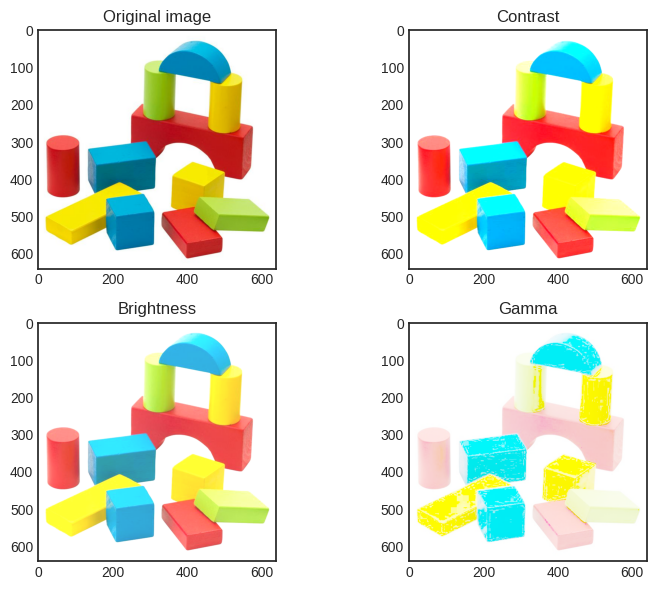

In [3]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Define the contrast and brightness parameters
contrast = 1.5
brightness = 50

# Apply the contrast and brightness
blocks_contrasted = cv2.convertScaleAbs(blocks_original, alpha=contrast, beta=None)
blocks_brightness = cv2.convertScaleAbs(blocks_original, alpha=None, beta=brightness)

# Adjust the gamma
blocks_gamma = adjust_gamma(blocks_original, gamma=0.1)

# Plot the adjusted images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax = axes.ravel()
ax[0].imshow(blocks_original)
ax[0].set_title('Original image')
ax[1].imshow(blocks_contrasted)
ax[1].set_title('Contrast')
ax[2].imshow(blocks_brightness)
ax[2].set_title('Brightness')
ax[3].imshow(blocks_gamma)
ax[3].set_title('Gamma')
fig.tight_layout()
plt.show()

### Resize, Rescale and Smooth

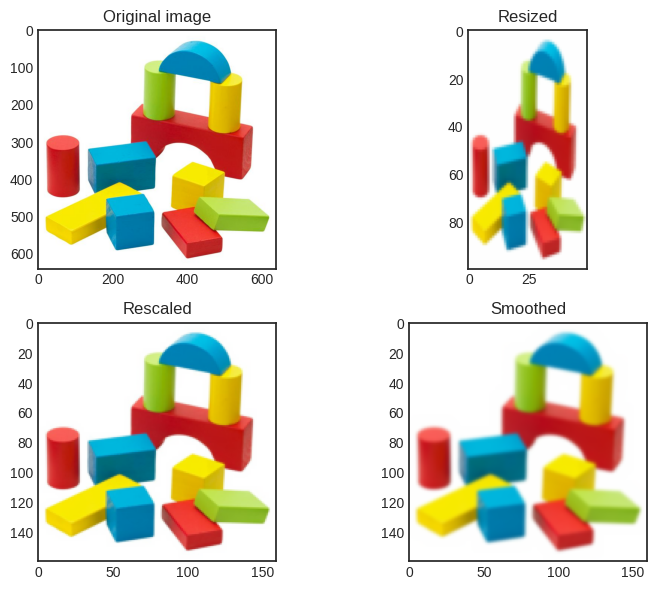

In [5]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Resize the image
blocks_resized = resize(blocks_original, (100, 50), anti_aliasing=True)

# Rescale the image
blocks_rescaled = rescale(blocks_original, 0.25, channel_axis=2, anti_aliasing=True)

# Smooth the image
blocks_smoothed = gaussian(blocks_rescaled, sigma=1, channel_axis=2)

# Display the images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax = axes.ravel()
ax[0].imshow(blocks_original)
ax[0].set_title("Original image")
ax[1].imshow(blocks_resized)
ax[1].set_title("Resized")
ax[2].imshow(blocks_rescaled)
ax[2].set_title("Rescaled")
ax[3].imshow(blocks_smoothed)
ax[3].set_title("Smoothed")
fig.tight_layout()
plt.show()

### Translate, Rotate and Transform

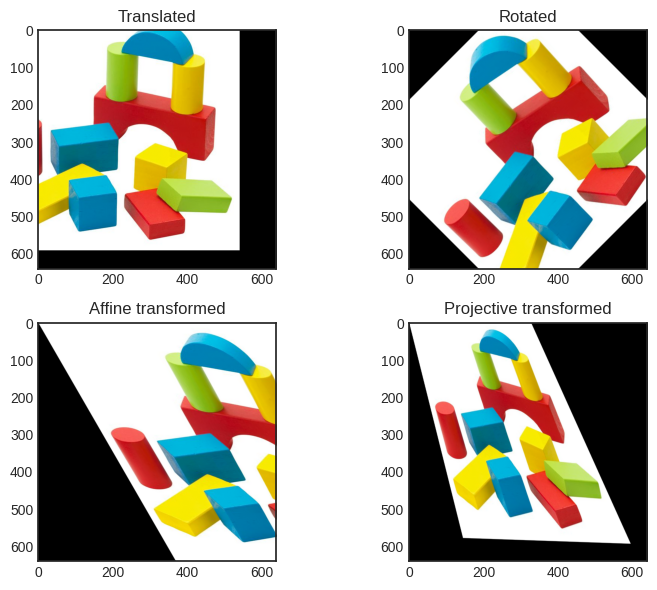

In [6]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Translate the image
t_transform = SimilarityTransform(translation=(100, 50))
blocks_translated = warp(blocks_original, t_transform)

# Rotate the image
blocks_rotated = rotate(blocks_original, 45)

# Affine Transform the image
aff_transform = AffineTransform(shear=np.pi/6)
blocks_rescaled = warp(blocks_original, aff_transform)

# Projective Transform the image
matrix = np.array([[2, -0.5, 0],
                   [0.0, 1.5, 0],
                   [0.00006, 0.0006, 1]])
proj_transform = ProjectiveTransform(matrix)
blocks_projective = warp(blocks_original, proj_transform)

# Display the images
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
ax = axes.ravel()
ax[0].imshow(blocks_translated)
ax[0].set_title("Translated")
ax[1].imshow(blocks_rotated)
ax[1].set_title("Rotated")
ax[2].imshow(blocks_rescaled)
ax[2].set_title("Affine transformed")
ax[3].imshow(blocks_projective)
ax[3].set_title("Projective transformed")
fig.tight_layout()
plt.show()

## 1.2 Image properties

### Edge Detection

Not really pre-processing but a similar result to Larry Roberts' work on edge detection.

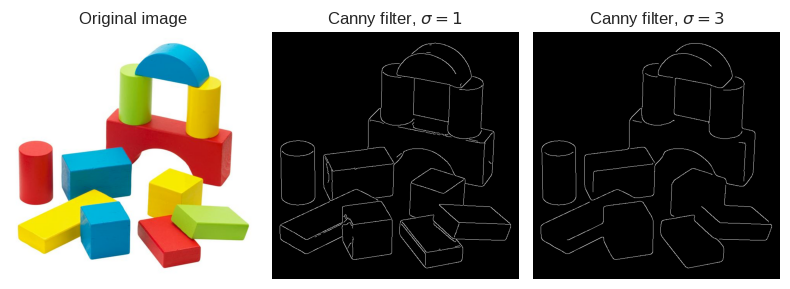

In [7]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Compute the Canny filter for two values of sigma
blocks_greyscale = rgb2gray(blocks_original)
edges1 = feature.canny(blocks_greyscale)
edges2 = feature.canny(blocks_greyscale, sigma=3)

# Display the images
fig, ax = plt.subplots(1, 3, figsize=(8, 6))
ax[0].imshow(blocks_original, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(edges1, cmap='gray')
ax[1].set_title(r'Canny filter, $\sigma=1$')
ax[2].imshow(edges2, cmap='gray')
ax[2].set_title(r'Canny filter, $\sigma=3$')
for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

### Corner Detection

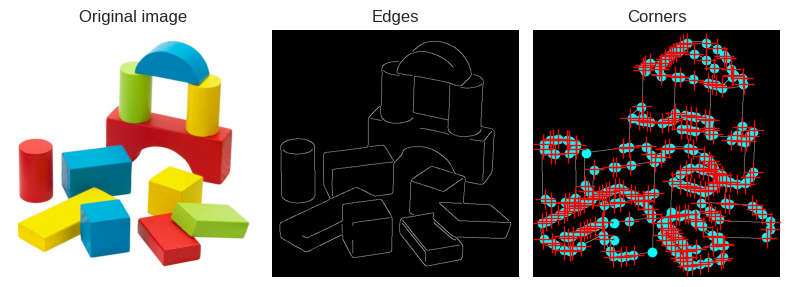

In [8]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Compute the Canny filter for two values of sigma
blocks_greyscale = rgb2gray(blocks_original)
edges = feature.canny(blocks_greyscale, sigma=2)

# Find corners with the Harris corner detector
coords = feature.corner_peaks(feature.corner_harris(edges), min_distance=5, threshold_rel=0.02)
coords_subpix = feature.corner_subpix(edges, coords, window_size=13)

# Display the images
fig, ax = plt.subplots(1, 3, figsize=(8, 6))
ax[0].imshow(blocks_original, cmap='gray')
ax[0].set_title('Original image')
ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Edges')
ax[2].imshow(edges, cmap='gray')
ax[2].plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=6)
ax[2].plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax[2].set_title('Corners')
for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

### Center of Mass and Bounding Box

The following demonstrates how some relatively simple image manipulation can be used to find different regions (or "blobs") within an image. Once distinct regions have been identified the center point (centroid), area, perimeter, bounding box, etc can be calculated.

1. First convert the image to greyscale and find the threshold value. All pixels with values greater than the threshold are considered part of the foreground, and values lower than the threshold are background.

2. Using the threshold the image can be converted to black and white (binary).

3. With a binary image the properties of each distinct region can be found, such as the center, the area, the perimeter, etc. In this case there is only one region.

Threshold value :  0.693
Centroid : (354.41, 335.56)


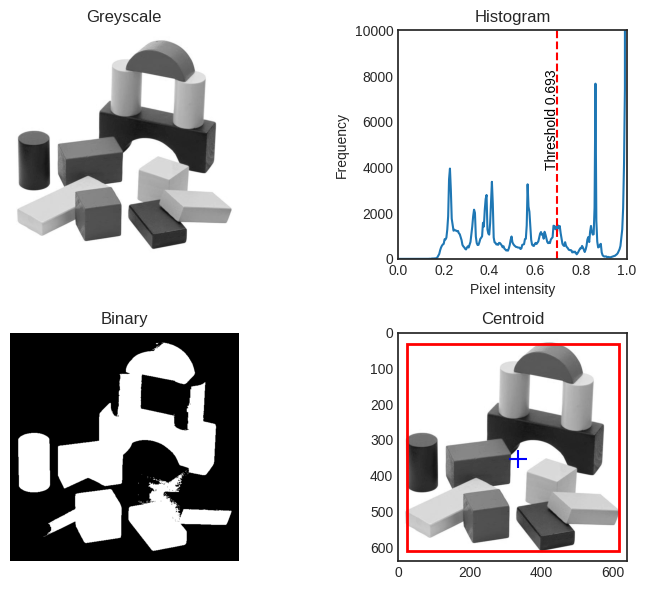

In [9]:
# Load the image
blocks_original = io.imread(os.path.join(images_dir, 'toy_blocks.jpg'))

# Convert to greyscale
blocks_greyscale = rgb2gray(blocks_original)

# Compute the histogram
histogram, bin_edges = np.histogram(blocks_greyscale, bins=256, range=(0.0, 1.0))

# Find the threshold value
thresh = threshold_otsu(blocks_greyscale)
print("Threshold value : ", round(thresh, 4))

# Binarize the image, pixels with value > thresh are set to 1 (foreground), else 0 (background)
blocks_binary = (blocks_greyscale <= thresh).astype(int)

# Find the properties of the image regions (centroid, area, perimeter, etc.)
region_props = regionprops(blocks_binary, blocks_greyscale)

# Get centroid and bounding box
centroid = region_props[0].centroid
print("Centroid : ({:.2f}, {:.2f})".format(centroid[0], centroid[1]))

min_row, min_col, max_row, max_col = region_props[0].bbox
bbox = mpatches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, fill=False, edgecolor='r', linewidth=2)

# Display the images
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()
ax[0].imshow(blocks_greyscale, cmap='gray')
ax[0].set_title("Greyscale")
ax[0].axis('off')

ax[1].plot(bin_edges[0:-1], histogram)
ax[1].set_title("Histogram")
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 10000])
ax[1].axvline(x=thresh, color = 'r', linestyle = '--')
ax[1].text(x=thresh - 0.05, y=4000, s='Threshold {:.3f}'.format(thresh), color='black', rotation=90)
ax[1].set_xlabel("Pixel intensity")
ax[1].set_ylabel("Frequency")
asp = np.diff(ax[1].get_xlim())[0] / np.diff(ax[1].get_ylim())[0]
ax[1].set_aspect(asp)

ax[2].imshow(blocks_binary, cmap='gray')
ax[2].set_title("Binary")
ax[2].axis('off')

ax[3].imshow(blocks_greyscale, cmap='gray')
ax[3].scatter(centroid[1], centroid[0], s=160, c='b', marker='+')
ax[3].add_patch(bbox)
ax[3].set_title("Centroid")

fig.tight_layout()
plt.show()

### Simple image segmentation

For images with more than one distinct region it only requires a few more step to perform simple image segmentation. Once the image has been converted to binary the distinct regions can be assigned unique labels and even colourised. Then the properties of each unique region can be identified and the bounding box used to separate them into different images.

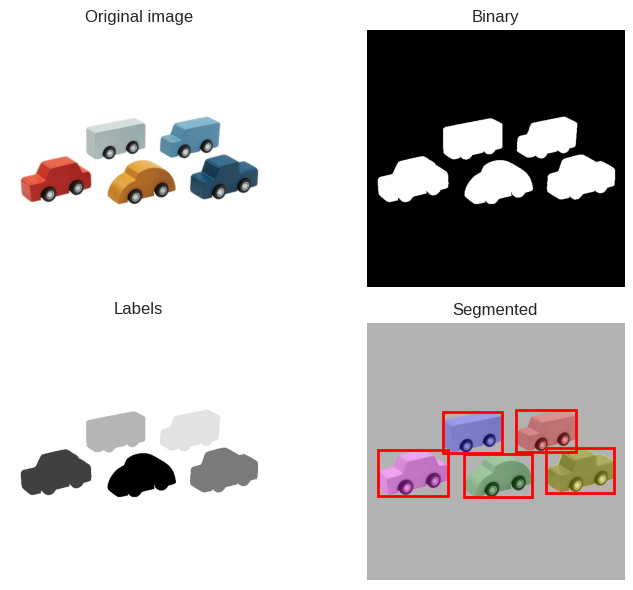

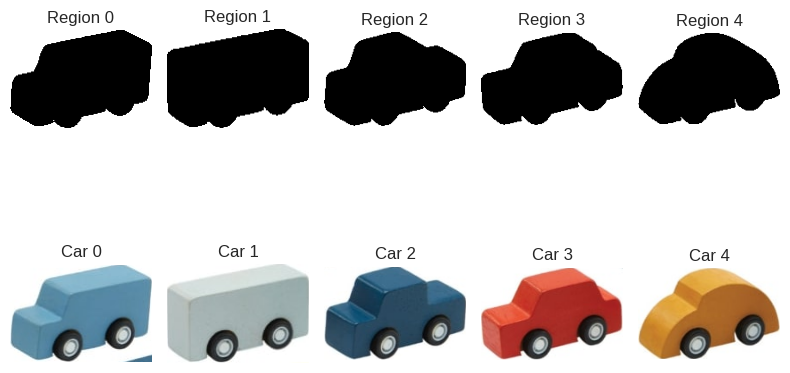

In [10]:
# Load the image
cars_original = io.imread(os.path.join(images_dir, 'toy_cars.jpg'))

# Convert to greyscale
cars_greyscale = rgb2gray(cars_original)

# Find the threshold value
thresh = threshold_mean(cars_greyscale)

# Binarize the image, pixels with value > thresh are set to 1 (foreground), else 0 (background)
cars_binary = (cars_greyscale <= thresh).astype(int)

# Label image regions
cars_labels = label(cars_binary)

# Colourise the image regions based on the label
# `bg_label` is the label value of the background and `overlay` assigns a different color to each region
cars_label_overlay = label2rgb(cars_labels, image=cars_original, bg_label=0, kind='overlay')

# Find the properties of the image regions (centroid, area, perimeter, etc.)
region_props = regionprops(cars_labels)

# Get bounding box for each region
bboxes = []
for region in region_props:
    # Only consider regions with large enough areas
    if region.area >= 100:
        # Draw rectangle around segments
        min_row, min_col, max_row, max_col = region.bbox
        bboxes.append(mpatches.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row, fill=False, edgecolor='r', linewidth=2))

# Display the images
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
ax = ax.ravel()
ax[0].imshow(cars_original)
ax[0].set_title("Original image")
ax[1].imshow(cars_binary, cmap='gray')
ax[1].set_title("Binary")
ax[2].imshow(cars_labels)
ax[2].set_title("Labels")
ax[3].imshow(cars_label_overlay)
ax[3].set_title("Segmented")
for box in bboxes:
    ax[3].add_patch(box)
for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

# Display the image regions
fig, ax = plt.subplots(2, len(region_props), figsize=(8, 6))
for i, region in enumerate(region_props):
    # Plot the region
    ax[0, i].imshow(region.image)
    ax[0, i].set_title("Region {}".format(i))
    ax[0, i].axis('off')
    # Plot the region cropped from the original image
    min_row, min_col, max_row, max_col = region.bbox
    ax[1, i].imshow(cars_original[min_row:max_row, min_col:max_col])
    ax[1, i].set_title("Car {}".format(i))
    ax[1, i].axis('off')
fig.tight_layout()
plt.show()

<div class="alert alert-info" style="color:black"><h2>1.3 Exercise: Gathering handwritten digits</h2>

We have now seen various pre-processing options and a simple technique for image segmentation. Next week we will be building classifiers for the classic [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, which contains 70,000 images of handwritten digits, and is often used for understanding image classification. So, lets create our own small set of images to use as a test set!

1. In the following cell complete the `segment_image()` function. It should take in the following arguments and return a list of the sub-images found during segmentation:
    - `input_image` is the input image to segment.
    - `threshold` is the thresholding method to use, either `otsu` or `mean`.
    - `min_area` is the minimum area of a region to be considered a sub-image

2. You can adapt the code used in the previous cells to segment the toy cars to segment your digits from the single image.

3. Your code should use a different thresholding method (otsu or mean), depending on the `threshold` parameter. You should use the otsu method for testing on digits.

3. You may find that small artefacts on the input image are interpreted as regions. Your code should remove any regions with `area < min_area`.

4. You may also find that some regions are all one colour (in this case 0, or 1). Your code should remove any regions that are all 0's or 1's.

4. The segmented images should be a numpy array of `bool` data type.

To test your function first write each of the 10 digits (0 to 9) on a piece of plain paper. Then, use your phone, or another camera, to take a picture of the digits. Depending on lighting it may help to turn on the flash to avoid too much shadow. Optionally, you could manually crop the photo to reduce the size a little. Save this image as `my_digits.jpg` in the data/my_digits folder.

<b>MARKS AVAILABLE: 5</b>
<br>
<b>MO1</b>
</div>

<div class="alert alert-success" style="color:black"><b>Note:</b> You may find that the labelled regions are not assigned in the same order as the digits, which makes storing the images in the correct order awkward (e.g. for saving). Assuming your digits are written left to right (0 to 9), <em>on one line</em>, you can use this code snippet to re-order the regions by increasing x coordinates of their centroids.<br>

<code>region_props = sorted(region_props, key=lambda region: region.centroid[1])</code>
</div>

In [5]:
def segment_image(input_image, threshold='otsu', min_area=100):
    """Segments the input image into individual images.
    
    Arguments:
        input_image (numpy.ndarray): The input image to segment
        threshold (str): The thresholding method to use (either 'otsu' or 'mean')
        min_area (int): The minimum area of a region to be considered a sub-image
    """
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    # Convert the image to greyscale
    grey_image = rgb2gray(input_image)
    
    # Apply otsu thresholding
    thresh = threshold_otsu(grey_image)
    #print("Threshold value : ", round(thresh, 4))

    # Binarise the image, pixels with value > thresh are set to 1 (foreground), else 0 (background)
    binary_image = (grey_image <= thresh).astype(int)
    
    # Label the image regions
    labelled_image = label(binary_image)
    
    # Get the properties of the image regions
    region_props = regionprops(labelled_image, grey_image)
    
    # Sort the regions by their centroids' x coordinates
    region_props = sorted(region_props, key=lambda region: region.centroid[1])
    
    # Filter regions 
    filtered_regions = [region.image for region in region_props 
                         if region.area >= min_area 
                         and not np.all(region.image == 0) 
                         and not np.all(region.image == 1)]
    
    return filtered_regions

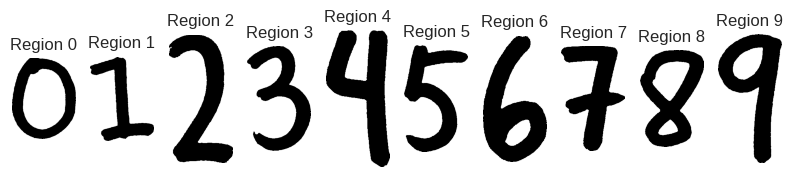

In [6]:
# Load the image of digits
my_digits = io.imread(os.path.join(data_dir, 'my_digits.jpg'))

# Segment the digits
segmented_digits = segment_image(my_digits, threshold='otsu', min_area=100)

# Display the segmented digits
fig, ax = plt.subplots(1, len(segmented_digits), figsize=(8, 6))
for i, digit in enumerate(segmented_digits):
    # Plot the region
    ax[i].imshow(digit)
    ax[i].set_title("Region {}".format(i))
    ax[i].axis('off')
fig.tight_layout()
plt.show()

In [18]:
# Test cell (2 marks)

# Load the image of digits
my_digits = io.imread(os.path.join(data_dir, 'my_digits.jpg'))

# Segment the digits
segmented_digits = segment_image(my_digits, threshold='otsu', min_area=100)

# Test the segmented digits are a list
assert isinstance(segmented_digits, list), "Segmented digits should be a list"

# Test the correct number of digits were segmented
assert len(segmented_digits) == 10, "Incorrect number of digits segmented"

# Test the segmented digits are numpy arrays
assert isinstance(segmented_digits[0], np.ndarray), "Segmented digits should be numpy arrays"

# Test the segmented digits are binary
assert np.all(np.logical_or(segmented_digits[0] == 0, segmented_digits[0] == 1)), "Segmented digits should be binary"
assert segmented_digits[0].dtype == bool, "Segmented digits should be binary"

# Test the segmented digits are the correct area
for digit in segmented_digits:
    assert digit.shape[0] * digit.shape[1] >= 100, "Segmented digits should be at least 100 pixels"

# Test the values are not all 0 or 1
for digit in segmented_digits:
    assert not np.all(digit == 0) and not np.all(digit == 1), "Segmented digits should not be all 0 or 1"

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (1 mark)
# Tests a slightly different digit image with extra regions


In [19]:
# Test cell (1 mark)

# Load the image of toy cars
toy_cars = io.imread(os.path.join(images_dir, 'toy_cars.jpg'))

# Segment the cars
segmented_cars = segment_image(toy_cars, threshold='mean', min_area=1000)

# Test the segmented cars are a list
assert isinstance(segmented_cars, list), "Segmented cars should be a list"

# Test the correct number of cars were segmented
assert len(segmented_cars) == 5, "Incorrect number of cars segmented"

# Test the segmented cars are numpy arrays
assert isinstance(segmented_cars[0], np.ndarray), "Segmented cars should be numpy arrays"

# Test the segmented cars are binary
assert np.all(np.logical_or(segmented_cars[0] == 0, segmented_cars[0] == 1)), "Segmented cars should be binary"
assert segmented_cars[0].dtype == bool, "Segmented cars should be binary"

# Test the segmented cars are the correct area
for car in segmented_cars:
    assert car.shape[0] * car.shape[1] >= 1000, "Segmented cars should be at least 1000 pixels"

# Test the values are not all 0 or 1
for car in segmented_cars:
    assert not np.all(car == 0) and not np.all(car == 1), "Segmented cars should not be all 0 or 1"

print('All tests passed!')

All tests passed!


In [ ]:
# Hidden test cell (1 mark)
# Tests cars image segmentation with different region sizes


### 1.3.1 Save the digits

Once you have completed your function, save each of the images as separate files in a folder called `my_digits`, and name them e.g. `digit_1.jpg`, etc. You should have 10 images that look something like this:

![segmented digits](../../../shared/images/segmented_digits.png)

<div class="alert alert-success" style="color:black"><b>Note:</b> We need to convert the images back to an unsigned 8 bit integer before saving using the function <code>img_as_ubyte()</code>.
</div>

In [12]:
if not grading:
    # Load the image of digits
    my_digits = io.imread(os.path.join(data_dir, 'my_digits.jpg'))

    # Segment the digits
    segmented_digits = segment_image(my_digits)

    # Save the segmented digits
    for i, digit in enumerate(segmented_digits):
        io.imsave(os.path.join(data_dir, 'my_digits', 'digit_{}.jpg'.format(i)), img_as_ubyte(digit))

<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280